In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.linalg import ishermitian

In [73]:
def Pauli():
    s0 = np.eye(2, dtype = complex)
    sx = np.array([[0, 1], [1, 0]], dtype = complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype = complex)
    sz = np.array([[1, 0], [0, -1]], dtype = complex)

    sp = (sx + 1j*sy)/2
    sm = (sx - 1j*sy)/2
    return s0, sx, sy, sz, sp, sm

def commutator(A, B):
    return A@B - B@A

def anticommutator(A, B):
    return A@B + B@A

def create_string(N, site, op, s0):
    if N < 10:
        if site == 0:
            string = op
            for i in range(N-1):
                string = np.kron(string, s0)
            return string
        else:
            string = s0
            for i in range(1, N):
                if i == site:
                    string = np.kron(string, op)
                else:
                    string = np.kron(string, s0)
        return string
    else:
        pass#return create_string_sparse(N, site, op, s0)

def hamiltonian(N, J, D, s0, sx, sy, sz):
    sxi = create_string(N, 0, sx, s0)
    sxip1 = create_string(N, 0+1, sx, s0)

    syi = create_string(N, 0, sy, s0)
    syip1 = create_string(N, 0+1, sy, s0)

    szi = create_string(N, 0, sz, s0)
    szip1 = create_string(N, 0+1, sz, s0)

    Ham = J*(sxi@sxip1 + syi@syip1 + D*(szi@szip1))
    for i in range(1, N-1):
        sxi = create_string(N, i, sx, s0)
        sxip1 = create_string(N, i+1, sx, s0)

        syi = create_string(N, i, sy, s0)
        syip1 = create_string(N, i+1, sy, s0)

        szi = create_string(N, i, sz, s0)
        szip1 = create_string(N, i+1, sz, s0)
        Ham = Ham + J*(sxi@sxip1 + syi@syip1 + D*(szi@szip1))
    return Ham

def cal_D(L):
    Id = np.eye(len(L), dtype = complex)
    aux1 = np.kron(L.conj(), L)
    aux2 = np.kron(Id, (L.T.conj()@L))
    aux3 = np.kron((L.T.conj()@L).T, Id)

    return aux1 - (aux2 + aux3)/2

def dissipator(op1, op2, gamma, f):
    return gamma*(f*cal_D(op1) + (1-f)*cal_D(op2))

def GSKL(H, dissipators):
    Id = np.eye(len(H), dtype = complex)
    return -1j*(np.kron(Id, H) - np.kron(H.T, Id)) + dissipators

In [74]:
s0, sx, sy, sz, sp, sm = Pauli()

N = 4

H = hamiltonian(N, 1, 1, s0, sx, sy, sz)

op01 = create_string(N, 0, sp, s0)
op02 = create_string(N, 0, sm, s0)

op11 = create_string(N, N-1, sp, s0)
op12 = create_string(N, N-1, sm, s0)

D1 = dissipator(op01, op02, 0.1, 1)
DN = dissipator(op11, op12, 0.1, 0)

Liouv = GSKL(H, D1 + DN)


In [75]:

M = Liouv.T.conj()@Liouv

print(ishermitian(M))

False


In [76]:
eigvals, eigvecs = eigsh(M, k = 2, which = 'SA')

In [77]:
rho_NESS = np.reshape(eigvecs[:, 0], (2**N, 2**N), order = 'F')
obs_op = []
for i in range(N):
  sztot = create_string(N, i, sz, s0)
  obs_op.append(np.real(np.trace(rho_NESS@sztot)/np.trace(rho_NESS)))
  #obs_op.append(sztot)

print(np.trace(rho_NESS))
#print(np.round(rho_NESS/np.trace(rho_NESS), 2))
print(eigvals[0])

(-3.7652526452921755-1.3052417864102308j)
2.6353580090162054e-14


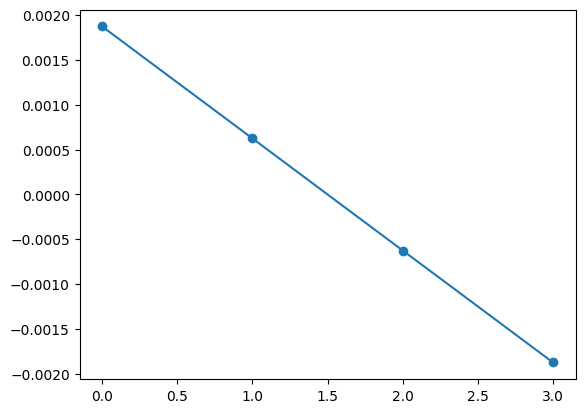

In [79]:
plt.plot(obs_op, '-o')